1) 데이터 준비와 확인

2) 데이터로더 구성

3) 모델구성을 위한 데이터 분석 및 가공

    데이터셋 내 문장 길이 분포
    적절한 최대 문장 길이 지정
    keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

4) 모델구성 및 validation set 구성

   모델은 3가지 이상 다양하게 구성하여 실험해 보세요.
   
5) 모델 훈련 개시

6) Loss, Accuracy 그래프 시각화

7) 학습된 Embedding 레이어 분석 - 유사도 단어
    
8) 한국어 Word2Vec 임베딩 활용하여 성능개선

## (E4)Sentimental_Analysis_of_Movie_Dataset_from_NAVER_InYu
### 1) 데이터 준비와 확인 & 2) 데이터로더 구성 

In [1]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter
from tensorflow.python.keras.callbacks import EarlyStopping

train_data = pd.read_table('~/aiffel/sentiment_classification/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/ratings_test.txt')

from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True) # 어떤 비율로 train과 test를 나눴는지 모르겠음
    test_data = test_data.dropna(how = 'any') 

    x_train = []
    for sentence in train_data['document']:
        temp_x = tokenizer.morphs(sentence) # 토큰화
        temp_x = [word for word in temp_x if not word in stopwords] # 불용어 제거
        x_train.append(temp_x)

    x_test = []
    for sentence in test_data['document']:
        temp_x = tokenizer.morphs(sentence) # 토큰화
        temp_x = [word for word in temp_x if not word in stopwords] # 불용어 제거
        x_test.append(temp_x)


    words = np.concatenate(x_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)    
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)} # enumerate 열거하다

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    x_train = list(map(wordlist_to_indexlist, x_train))
    x_test = list(map(wordlist_to_indexlist, x_test))

    return x_train, np.array(list(train_data['label'])), x_test, np.array(list(test_data['label'])), word_to_index

x_train, y_train, x_test, y_test, word_to_index = load_data(train_data, test_data)

print(len(x_train))
print(len(x_test))

146182
49157


In [23]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [2]:
total_data_text = list(x_train) + list(x_test)
# 텍스트 데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + round(2.5 * np.std(num_tokens))
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens)*100 / len(num_tokens)))

문장길이 평균 :  15.96938143432699
문장길이 최대 :  116
문장길이 표준편차 :  12.843571939469296
pad_sequences maxlen :  47
전체 문장의 95.2175448835102%가 maxlen 설정값 이내에 포함됩니다. 


In [3]:
# post
x_train = keras.preprocessing.sequence.pad_sequences(x_train,
                                                       value=word_to_index["<PAD>"],
                                                       padding='post',
                                                       maxlen=maxlen)

x_test = keras.preprocessing.sequence.pad_sequences(x_test,
                                                      value=word_to_index["<PAD>"],
                                                      padding='post',
                                                      maxlen=maxlen)

In [4]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 8  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

#LSTM
model_LSTM = Sequential()
model_LSTM.add(Embedding(vocab_size, 100))
model_LSTM.add(LSTM(128))
model_LSTM.add(Dense(1, activation='sigmoid'))


#Conv1D
model_CNN = keras.Sequential()
model_CNN.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_CNN.add(keras.layers.Conv1D(16, 7, activation='relu'))
model_CNN.add(keras.layers.MaxPooling1D(5))
model_CNN.add(keras.layers.Conv1D(16, 7, activation='relu'))
model_CNN.add(keras.layers.GlobalMaxPooling1D())
model_CNN.add(keras.layers.Dense(8, activation='relu'))
model_CNN.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.


#GlobalMaxPooling1D() 레이어 하나만 사용하는 방법
#전체 문장 중에서 단 하나의 가장 중요한 단어만 피처로 추출하여 그것으로 문장의 긍정/부정을 평가하는 방식
model_GlobMP = keras.Sequential()
model_GlobMP.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_GlobMP.add(keras.layers.GlobalMaxPooling1D())
#model_GlobMP.add(keras.layers.Dropout(0.3))
model_GlobMP.add(keras.layers.Dense(8, activation='relu'))
#model_GlobMP.add(keras.layers.Dropout(0.3))
model_GlobMP.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.


# RNN
model_RNN = keras.Sequential()
model_RNN.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,))) # 동일 # model의 첫번째 레이어
model_RNN.add(keras.layers.Conv1D(16, 7, activation='relu'))
model_RNN.add(keras.layers.MaxPooling1D(5))
model_RNN.add(keras.layers.Conv1D(16, 7, activation='relu'))
model_RNN.add(keras.layers.GlobalMaxPooling1D())
model_RNN.add(keras.layers.Dense(8, activation='relu')) # 동일
model_RNN.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다. # 동일


model_LSTM.summary()
model_CNN.summary()
model_GlobMP.summary()
model_RNN.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         1000000   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               117248    
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 1,117,377
Trainable params: 1,117,377
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 8)           80000     
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          912       
________________________

검증 데이터 손실(val_loss)이 증가하면, 과적합 징후므로 검증 데이터 손실이 4회 증가하면 학습을 조기 종료(Early Stopping)합니다. 또한, ModelCheckpoint를 사용하여 검증 데이터의 정확도(val_acc)가 이전보다 좋아질 경우에만 모델을 저장합니다.

In [5]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [6]:
print('LSTM------------------------------------------------------------------------------------------------------')
model_LSTM.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

history_model_LSTM = model_LSTM.fit(x_train, y_train, epochs=10, callbacks=[es, mc], batch_size=60, validation_split=0.2)

# test 는 "evaluate"
results_LSTM = model_LSTM.evaluate(x_test,  y_test, verbose=2)

print(results_LSTM)

LSTM------------------------------------------------------------------------------------------------------
Epoch 1/10
1949/1950 [============================>.] - ETA: 0s - loss: 0.4175 - acc: 0.8082
Epoch 00001: val_acc improved from -inf to 0.74789, saving model to best_model.h5
1950/1950 [==============================] - 65s 33ms/step - loss: 0.4175 - acc: 0.8082 - val_loss: 0.5502 - val_acc: 0.7479
Epoch 2/10
1950/1950 [==============================] - ETA: 0s - loss: 0.3344 - acc: 0.8584
Epoch 00002: val_acc improved from 0.74789 to 0.84814, saving model to best_model.h5
1950/1950 [==============================] - 79s 41ms/step - loss: 0.3344 - acc: 0.8584 - val_loss: 0.3800 - val_acc: 0.8481
Epoch 3/10
1948/1950 [============================>.] - ETA: 0s - loss: 0.3084 - acc: 0.8692
Epoch 00003: val_acc improved from 0.84814 to 0.86510, saving model to best_model.h5
1950/1950 [==============================] - 65s 33ms/step - loss: 0.3084 - acc: 0.8692 - val_loss: 0.3206 - val

In [7]:
print('CNN------------------------------------------------------------------------------------------------------')
model_CNN.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

history_model_CNN = model_CNN.fit(x_train, y_train, epochs=10, callbacks=[es, mc], batch_size=60, validation_split=0.2)

# test 는 "evaluate"
results_CNN = model_CNN.evaluate(x_test,  y_test, verbose=2)

print(results_CNN)

CNN------------------------------------------------------------------------------------------------------
Epoch 1/10
1937/1950 [============================>.] - ETA: 0s - loss: 0.4326 - acc: 0.7945
Epoch 00001: val_acc did not improve from 0.87246
1950/1950 [==============================] - 4s 2ms/step - loss: 0.4322 - acc: 0.7948 - val_loss: 0.3599 - val_acc: 0.8440
Epoch 2/10
1922/1950 [============================>.] - ETA: 0s - loss: 0.3391 - acc: 0.8540
Epoch 00002: val_acc did not improve from 0.87246
1950/1950 [==============================] - 4s 2ms/step - loss: 0.3389 - acc: 0.8540 - val_loss: 0.3491 - val_acc: 0.8486
Epoch 3/10
1933/1950 [============================>.] - ETA: 0s - loss: 0.3192 - acc: 0.8640
Epoch 00003: val_acc did not improve from 0.87246
1950/1950 [==============================] - 4s 2ms/step - loss: 0.3191 - acc: 0.8641 - val_loss: 0.3400 - val_acc: 0.8532
Epoch 4/10
1948/1950 [============================>.] - ETA: 0s - loss: 0.3064 - acc: 0.8708
Epo

In [8]:
print('GlobMP------------------------------------------------------------------------------------------------------')
model_GlobMP.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

history_model_GlobMP = model_GlobMP.fit(x_train, y_train, epochs=10, callbacks=[es, mc], batch_size=60, validation_split=0.2)

# test 는 "evaluate"
results_GlobMP = model_GlobMP.evaluate(x_test,  y_test, verbose=2)

print(results_GlobMP)

GlobMP------------------------------------------------------------------------------------------------------
Epoch 1/10
1921/1950 [============================>.] - ETA: 0s - loss: 0.5066 - acc: 0.7672
Epoch 00001: val_acc did not improve from 0.87246
1950/1950 [==============================] - 2s 1ms/step - loss: 0.5054 - acc: 0.7676 - val_loss: 0.4188 - val_acc: 0.8104
Epoch 2/10
1924/1950 [============================>.] - ETA: 0s - loss: 0.4021 - acc: 0.8223
Epoch 00002: val_acc did not improve from 0.87246
1950/1950 [==============================] - 2s 1ms/step - loss: 0.4020 - acc: 0.8225 - val_loss: 0.4014 - val_acc: 0.8208
Epoch 3/10
1904/1950 [============================>.] - ETA: 0s - loss: 0.3863 - acc: 0.8320
Epoch 00003: val_acc did not improve from 0.87246
1950/1950 [==============================] - 2s 1ms/step - loss: 0.3867 - acc: 0.8319 - val_loss: 0.3943 - val_acc: 0.8267
Epoch 4/10
1926/1950 [============================>.] - ETA: 0s - loss: 0.3765 - acc: 0.8372


In [9]:
print('RNN------------------------------------------------------------------------------------------------------')
model_RNN.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

history_model_RNN = model_RNN.fit(x_train, y_train, epochs=10, callbacks=[es, mc], batch_size=60, validation_split=0.2)

# test 는 "evaluate"
results_RNN = model_RNN.evaluate(x_test,  y_test, verbose=2)

print(results_RNN)

RNN------------------------------------------------------------------------------------------------------
Epoch 1/10
1932/1950 [============================>.] - ETA: 0s - loss: 0.4237 - acc: 0.7998
Epoch 00001: val_acc did not improve from 0.87246
1950/1950 [==============================] - 4s 2ms/step - loss: 0.4231 - acc: 0.8002 - val_loss: 0.3593 - val_acc: 0.8433
Epoch 2/10
1947/1950 [============================>.] - ETA: 0s - loss: 0.3371 - acc: 0.8551
Epoch 00002: val_acc did not improve from 0.87246
1950/1950 [==============================] - 4s 2ms/step - loss: 0.3371 - acc: 0.8551 - val_loss: 0.3389 - val_acc: 0.8549
Epoch 3/10
1946/1950 [============================>.] - ETA: 0s - loss: 0.3160 - acc: 0.8646
Epoch 00003: val_acc did not improve from 0.87246
1950/1950 [==============================] - 4s 2ms/step - loss: 0.3161 - acc: 0.8645 - val_loss: 0.3457 - val_acc: 0.8507
Epoch 4/10
1938/1950 [============================>.] - ETA: 0s - loss: 0.3006 - acc: 0.8730
Epo

### 6) Loss, Accuracy 그래프 시각화
4개의 모델에 대한 history 가져오기

In [12]:
history_dict_LSTM = history_model_LSTM.history
history_dict_CNN = history_model_CNN.history
history_dict_GlobMP = history_model_GlobMP.history
history_dict_RNN = history_model_RNN.history
print(history_dict_GlobMP.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


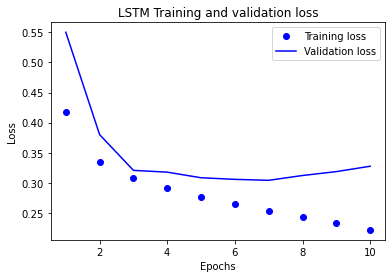

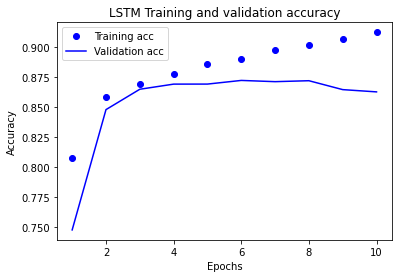

In [14]:
import matplotlib.pyplot as plt
# LSTM
acc = history_dict_LSTM['acc']
val_acc = history_dict_LSTM['val_acc']
loss = history_dict_LSTM['loss']
val_loss = history_dict_LSTM['val_loss']

epochs = range(1, len(acc) + 1)

#fig, ax = plt.subplots(1, 2, sharex=True) 
# fig란 figure로써 - 전체 subplot을 말한다. 
# ex) 서브플로안에 몇개의 그래프가 있던지 상관없이  그걸 담는 하나.전체 사이즈를 말한다.
# ax는 axe로써 - 전체 중 낱낱개를 말한다 
# ex) 서브플롯 안에 2개(a1,a2)의 그래프가 있다면 a1, a2 를 일컬음


# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('LSTM Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('LSTM Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

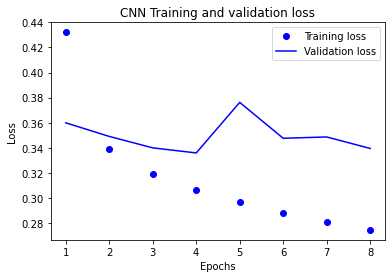

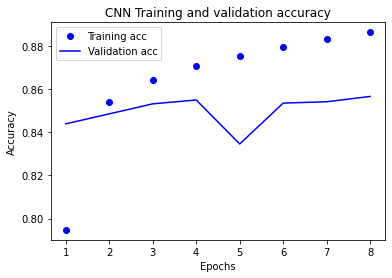

In [19]:
import matplotlib.pyplot as plt
# CNN
acc = history_dict_CNN['acc']
val_acc = history_dict_CNN['val_acc']
loss = history_dict_CNN['loss']
val_loss = history_dict_CNN['val_loss']

epochs = range(1, len(acc) + 1)

#fig, ax = plt.subplots(1, 2, sharex=True) 
# fig란 figure로써 - 전체 subplot을 말한다. 
# ex) 서브플로안에 몇개의 그래프가 있던지 상관없이  그걸 담는 하나.전체 사이즈를 말한다.
# ax는 axe로써 - 전체 중 낱낱개를 말한다 
# ex) 서브플롯 안에 2개(a1,a2)의 그래프가 있다면 a1, a2 를 일컬음


# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('CNN Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('CNN Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

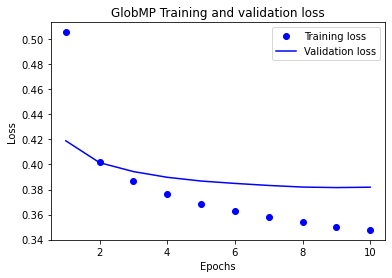

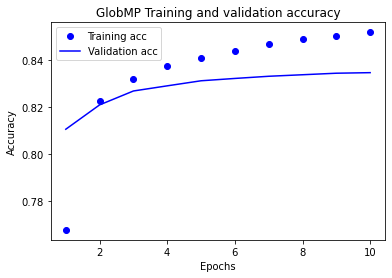

In [18]:
import matplotlib.pyplot as plt
# GlobMP
acc = history_dict_GlobMP['acc']
val_acc = history_dict_GlobMP['val_acc']
loss = history_dict_GlobMP['loss']
val_loss = history_dict_GlobMP['val_loss']

epochs = range(1, len(acc) + 1)

#fig, ax = plt.subplots(1, 2, sharex=True) 
# fig란 figure로써 - 전체 subplot을 말한다. 
# ex) 서브플로안에 몇개의 그래프가 있던지 상관없이  그걸 담는 하나.전체 사이즈를 말한다.
# ax는 axe로써 - 전체 중 낱낱개를 말한다 
# ex) 서브플롯 안에 2개(a1,a2)의 그래프가 있다면 a1, a2 를 일컬음


# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('GlobMP Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('GlobMP Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

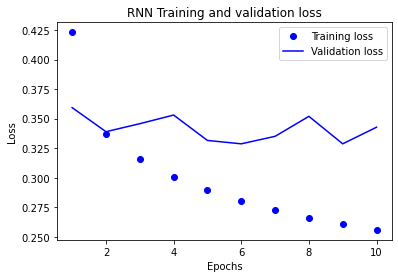

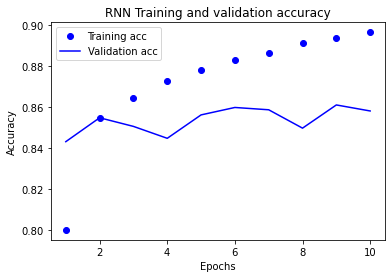

In [17]:
import matplotlib.pyplot as plt
# RNN
acc = history_dict_RNN['acc']
val_acc = history_dict_RNN['val_acc']
loss = history_dict_RNN['loss']
val_loss = history_dict_RNN['val_loss']

epochs = range(1, len(acc) + 1)

#fig, ax = plt.subplots(1, 2, sharex=True) 
# fig란 figure로써 - 전체 subplot을 말한다. 
# ex) 서브플로안에 몇개의 그래프가 있던지 상관없이  그걸 담는 하나.전체 사이즈를 말한다.
# ax는 axe로써 - 전체 중 낱낱개를 말한다 
# ex) 서브플롯 안에 2개(a1,a2)의 그래프가 있다면 a1, a2 를 일컬음


# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('RNN Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('RNN Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### 7) 학습된 Embedding 레이어 분석

In [36]:
#history_model_LSTM
#history_model_CNN
#history_model_GlobalMP
#history_model_RNN
embedding_layer = model_RNN.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 8)


### 1. LSTM으로 학습된 임베딩 파라미터를 word2vec_LSTM.txt에 저장

In [66]:
import os

# 학습한 Embedding 파라미터를 파일에 써서 저장합니다.
word2vec_file_path_LSTM = os.getenv('HOME')+'/aiffel/sentiment_classification/word2vec_LSTM.txt'
f = open(word2vec_file_path_LSTM, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors_LSTM = model_LSTM.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors_LSTM[i, :])))))
f.close()

### 2. CNN으로 학습된 임베딩 파라미터를 word2vec_CNN.txt에 저장

In [67]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다.
word2vec_file_path_CNN = os.getenv('HOME')+'/aiffel/sentiment_classification/word2vec_CNN.txt'
f = open(word2vec_file_path_CNN, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.
    
# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors_CNN = model_CNN.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors_CNN[i, :])))))
f.close()

### 3. GlobMP으로 학습된 임베딩 파라미터를 word2vec_GlobMP.txt에 저장

In [68]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다.
word2vec_file_path_GlobMP = os.getenv('HOME')+'/aiffel/sentiment_classification/word2vec_GlobMP.txt'
f = open(word2vec_file_path_GlobMP, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors_GlobMP = model_GlobMP.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors_GlobMP[i, :])))))
f.close()

### 4. RNN으로 학습된 임베딩 파라미터를 word2vec_RNN.txt에 저장

In [49]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다.
word2vec_file_path_RNN = os.getenv('HOME')+'/aiffel/sentiment_classification/word2vec_RNN.txt'
f = open(word2vec_file_path_RNN, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors_RNN = model_RNN.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors_RNN[i, :])))))
f.close()

In [72]:
import gensim
from gensim.models import KeyedVectors
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors01 = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path_LSTM, binary=False)
word_vectors02 = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path_CNN, binary=False)
word_vectors03 = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path_GlobalMP, binary=False)
word_vectors04 = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path_RNN, binary=False)

vectors_LSTM01 = model.get_weights()[0]
#vector_CNN = word_vectors['한국']
#vector_GlobalMP = word_vectors['한국']
#vector_RNN = word_vectors['한국']
vectors_LSTM01

ValueError: invalid vector on line 0 (is this really the text format?)

In [59]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors01 = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path_LSTM, binary=False)
word_vectors02 = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path_CNN, binary=False)
word_vectors03 = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path_GlobalMP, binary=False)
word_vectors04 = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path_RNN, binary=False)

vector = word_vectors01['한국']
#vector_CNN = word_vectors['한국']
#vector_GlobalMP = word_vectors['한국']
#vector_RNN = word_vectors['한국']
vector

ValueError: invalid vector on line 0 (is this really the text format?)

In [43]:
# LSTM학습된 임베딩
word_vectors01.similar_by_word("여름")

NameError: name 'word_vectors01' is not defined